In [1]:
import torch
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

from beschess.data.embedding import PuzzleDataset
from beschess.components.net.resnet import SEResEmbeddingNet
from beschess.components.loss import ProxyAnchor
from beschess.utils import packed_to_tensor
from beschess.viz import plot_distance_distributions

%load_ext autoreload
%autoreload 2

/home/jerry/School/5825 Bayesian ML/CSE5825_BML/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TAG_NAMES = [
    "quiet",
    "bishopEndgame",
    "diagonalMate",
    "discoveredAttack",
    "fork",
    "knightEndgame",
    "knightMate",
    "orthogonalMate",
    "pawnEndgame",
    "pin",
    "queenEndgame",
    "queenMate",
    "queenRookEndgame",
    "rookEndgame",
    "skewer",
    "xRayAttack",
]

In [3]:
data_dir = '../data/processed/'
quiet_boards_file = data_dir + 'quiet_boards_preeval.npy'
puzzle_boards_file = data_dir + 'boards_packed.npy'
puzzle_labels_file = data_dir + 'tags_packed.npy'

full_quiet_boards = np.load(quiet_boards_file, mmap_mode='r')
full_puzzle_boards = np.load(puzzle_boards_file, mmap_mode='r')
full_puzzle_labels = np.load(puzzle_labels_file, mmap_mode='r')

dataset = PuzzleDataset(
    quiet_boards=full_quiet_boards,
    puzzle_boards=full_puzzle_boards,
    puzzle_labels=full_puzzle_labels,
)


test_indices_file = open(data_dir + 'test_indices.txt', 'r')
test_indices = [int(line.split(',')[1]) for line in test_indices_file.readlines()]

test_boards = []
test_labels = []
for idx in test_indices:
    board, label = dataset[idx]
    test_boards.append(board)
    test_labels.append(label)

test_boards = np.asarray(test_boards)
test_labels = np.asarray(test_labels)
len(test_boards)

161426

In [4]:
# Force CPU-only execution
device = torch.device("cpu")
# CHECKPOINT = "../checkpoints/SEResEmbeddingNet_20251126_000940/checkpoint_epoch_10.pth"
CHECKPOINT = "../checkpoints/SEResEmbeddingNet_20251126_140421/best_checkpoint.pth"

In [5]:
model = SEResEmbeddingNet(embedding_dim=128, num_blocks=10, reduction=8)
checkpoint = torch.load(CHECKPOINT, map_location='cpu')
state = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint
model.load_state_dict(state)
model = model.to(device)
model.eval()

SEResEmbeddingNet(
  (conv_input): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_input): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_layers): Sequential(
    (0): SEResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=8, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=8, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1): SEResBlock(
      (conv1): C

In [6]:
# Run inference in minibatches on CPU to limit peak memory usage
batch_size = 64  # tune this for your machine
embeddings_list = []
model.eval()
with torch.no_grad():
    for i in range(0, len(test_boards), batch_size):
        batch = np.asarray(test_boards[i : i + batch_size])
        inputs = torch.from_numpy(batch).float()  # CPU tensors
        out = model(inputs)
        embeddings_list.append(out.numpy())
        # free intermediate variables
        del inputs, out
embeddings = np.vstack(embeddings_list)

Generating Distance Histogram...


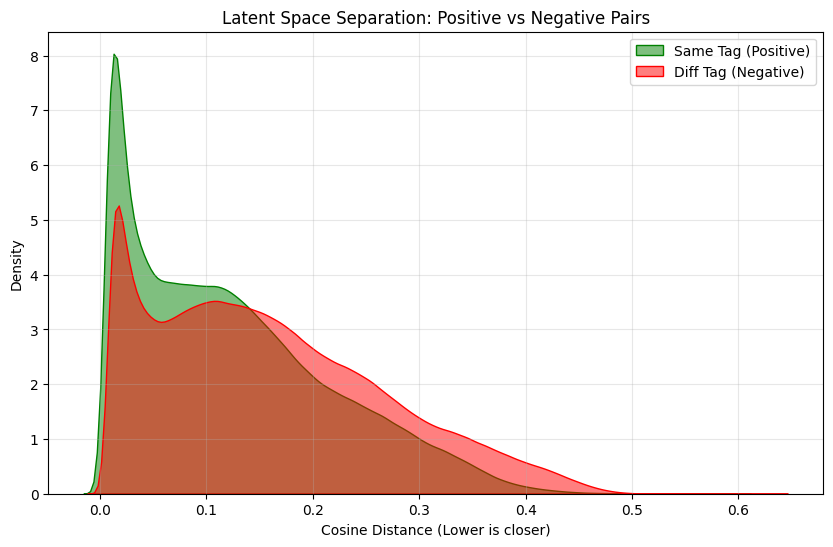

In [13]:
plot_distance_distributions(embeddings, np.asarray(test_labels))

In [8]:
umap_model = UMAP(n_components=2, random_state=42, metric='cosine')
embeddings_2d = umap_model.fit_transform(embeddings)

/home/jerry/School/5825 Bayesian ML/CSE5825_BML/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
single_label = np.argmax(test_labels, axis=1)
single_label.shape

(161426,)

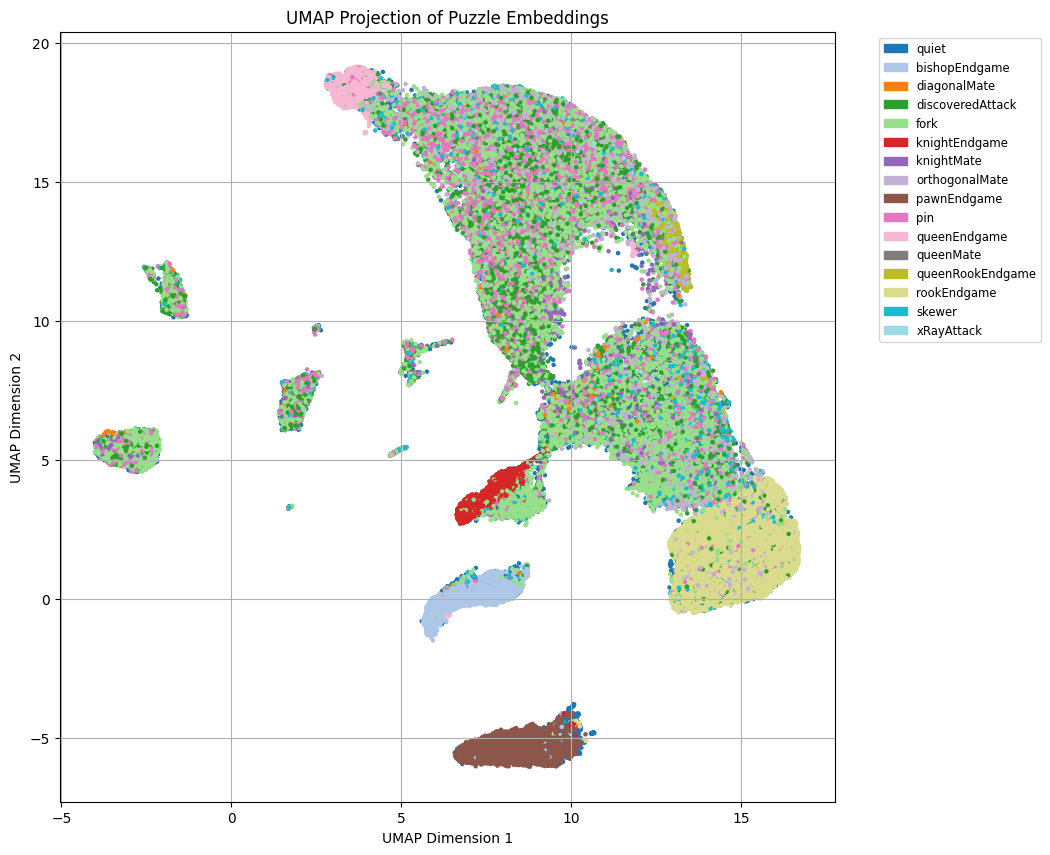

In [14]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=single_label, cmap='tab20', s=5)

# Build a legend only for the classes actually present by creating proxy artists.
# Use the exact colormap + normalization used by the scatter so legend colors match.
unique_classes = np.unique(single_label)

# Use scatter's colormap and normalization to compute the exact RGBA used for each class
cmap = getattr(scatter, 'cmap', plt.get_cmap('tab20'))
norm = getattr(scatter, 'norm', None)
if norm is None:
    # Fallback Normalize to match scatter's default behavior
    norm = plt.Normalize(vmin=single_label.min(), vmax=single_label.max())

color_map = [cmap(norm(int(c))) for c in unique_classes]

from matplotlib.patches import Patch
handles = [Patch(color=col) for col in color_map]
labels = [TAG_NAMES[int(c)] for c in unique_classes]

plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title('UMAP Projection of Puzzle Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()


In [12]:
# Notebook-friendly quiet leakage checker
# Accepts embeddings and multi-hot labels (no file IO)
from sklearn.neighbors import NearestNeighbors
import numpy as np


def check_quiet_leakage_from_arrays(embeddings, labels, n_neighbors=5, sample_size=5000, random_state=None):
    """Check how often a 'quiet' example (class 0) has tactical neighbors.

    Parameters
    ----------
    embeddings : np.ndarray, shape (N, D)
        Embedding vectors.
    labels : np.ndarray, shape (N, C)
        Multi-hot label matrix where column 0 indicates 'quiet' (1==quiet).
    n_neighbors : int
        Number of neighbors to query (includes the point itself). Default 5.
    sample_size : int
        How many quiet examples to sample when checking (for speed).
    random_state : int | None
        Random seed for reproducible sampling.

    Returns
    -------
    dict
        Summary statistics: leakage_rate, leakage_count, total_neighbors, sampled_quiet, verdict
    """
    if random_state is not None:
        np.random.seed(random_state)

    assert embeddings.shape[0] == labels.shape[0], "embeddings and labels must have same length"
    N = embeddings.shape[0]

    # Indices where class 0 (quiet) is present
    quiet_indices = np.where(labels[:, 0] == 1)[0]
    if quiet_indices.size == 0:
        print("No quiet examples found in labels (class 0).")
        return {
            "leakage_rate": None,
            "leakage_count": 0,
            "total_neighbors": 0,
            "sampled_quiet": 0,
            "verdict": "NO_QUIET"
        }

    # Fit nearest neighbors on the full embedding set
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(embeddings)

    actual_sample_size = min(sample_size, quiet_indices.size)
    query_idx = np.random.choice(quiet_indices, actual_sample_size, replace=False)

    distances, indices = nbrs.kneighbors(embeddings[query_idx])

    leakage_count = 0
    total_neighbors = 0

    for i in range(actual_sample_size):
        # indices[i] contains the queried index as the first entry (self) followed by neighbors
        if indices.shape[1] > 1:
            neighbor_ids = indices[i][1:]
        else:
            neighbor_ids = []

        for n_id in neighbor_ids:
            total_neighbors += 1
            # If neighbor is NOT quiet (i.e., tactical), count as leakage
            if labels[int(n_id), 0] == 0:
                leakage_count += 1

    leakage_rate = leakage_count / total_neighbors if total_neighbors > 0 else 0.0

    print(f"Sampled quiet examples: {actual_sample_size}")
    print(f"Total neighbors checked: {total_neighbors}")
    print(f"Leakage count (quiet -> tactical): {leakage_count}")
    print(f"Leakage rate: {leakage_rate:.2%}")

    if leakage_rate < 0.10:
        verdict = "PASS"
    elif leakage_rate < 0.25:
        verdict = "ACCEPTABLE"
    else:
        verdict = "FAIL"

    print(f"Verdict: {verdict}")

    return {
        "leakage_rate": leakage_rate,
        "leakage_count": leakage_count,
        "total_neighbors": total_neighbors,
        "sampled_quiet": actual_sample_size,
        "verdict": verdict
    }


# Example usage (uncomment to run):
stats = check_quiet_leakage_from_arrays(embeddings, test_labels, n_neighbors=5, sample_size=2000, random_state=42)
print(stats)


Sampled quiet examples: 2000
Total neighbors checked: 8000
Leakage count (quiet -> tactical): 3742
Leakage rate: 46.77%
Verdict: FAIL
{'leakage_rate': 0.46775, 'leakage_count': 3742, 'total_neighbors': 8000, 'sampled_quiet': 2000, 'verdict': 'FAIL'}
